## **Análisis de datos exploratorio**

En esta EDA se analiza el dataset **Chilean Company Directors** ([link a los datos](https://www.kaggle.com/datasets/sandorabad/chilean-company-directories-by-rut-14012021)) de Kaggle, que contiene información acerca de personas que han sido directores de empresas en Chile.

In [6]:
%pip install plotly matplotlib numpy pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx

In [8]:
data_path = '../data/'

In [9]:
directivos_df = pd.read_csv(data_path + 'directors_and_companies.csv')
directivos_df.head()

,Rut_individuo,Nombre,Cargo,Fecha_nombramiento,Fecha_termino,Rut_Empresa,Nombre_empresa
0,0-E,LUIS ORVAÑANOS LASCURAIN,Presidente,28/03/2012,NaN,59175530,"CORPORACION GEO, S.A.B. DE C.V."
1,0-E,EMILIO CUENCA FRIEDERICHSEN,Director,28/03/2012,NaN,59175530,"CORPORACION GEO, S.A.B. DE C.V."
2,0-E,ROBERTO ORVAÑANOS CONDE,Director,28/03/2012,NaN,59175530,"CORPORACION GEO, S.A.B. DE C.V."
3,0-E,IÑIGO ORVAÑANOS CORCUERA,Director,28/03/2012,NaN,59175530,"CORPORACION GEO, S.A.B. DE C.V."
4,0-E,RAUL ZORRILLA COSIO,Director,28/03/2012,NaN,59175530,"CORPORACION GEO, S.A.B. DE C.V."


Los ruts se ven un poco extraños. Veamos un dato random para ver como se ve algun otro rut.

In [10]:
directivos_df.iloc[2456, :]

Rut_individuo                      9.979.068-7
Nombre                ALBERTO EGUIGUREN CORREA
Cargo                                 Director
Fecha_nombramiento                  14/08/2018
Fecha_termino                       14/06/2019
Rut_Empresa                           76215637
Nombre_empresa            AGUAS ARAUCANIA S.A.
Name: 2456, dtype: object

Como se observa en el dataset, se poseen 7 columnas:
1. **Rut_individuo**: RUT de la persona.
2. **Nombre**: Nombre de la persona.
3. **Cargo**: Cargo que desempeñó en la empresa (son roles directivos: presidente, director, etc.).
4. **Fecha_nombramiento**: Fecha en que fue nombrado en el cargo.
5. **Fecha_termino**: Fecha en que terminó su cargo.
6. **Rut_empresa**: RUT de la empresa.
7. **Nombre_empresa**: Nombre de la empresa.

Veamos cuantos datos tenemos.

In [11]:
directivos_df.shape

(15841, 7)

Verifiquemos entre que fechas se encuentran los datos.

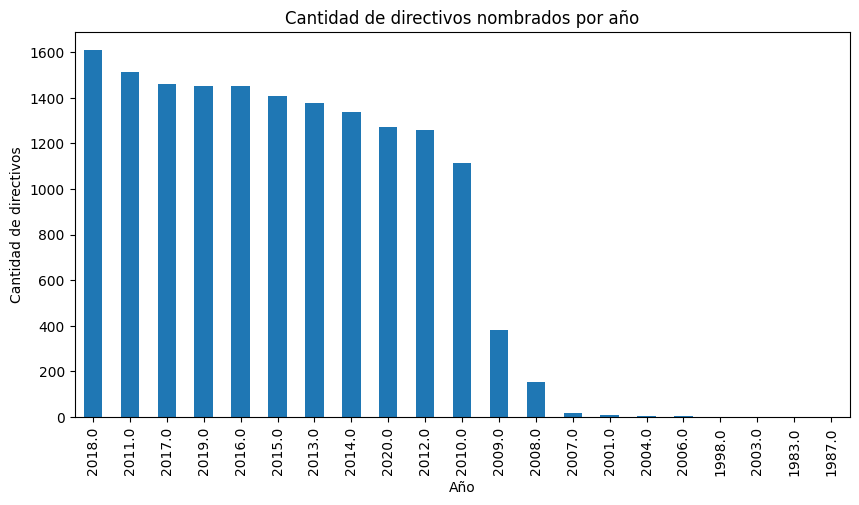

In [12]:
fecha_nombramiento = pd.to_datetime(directivos_df['Fecha_nombramiento'], errors='coerce', dayfirst=True)
cantidad_por_fecha = fecha_nombramiento.dt.year.value_counts()

plt.figure(figsize=(10, 5))
cantidad_por_fecha.plot(kind='bar')
plt.title('Cantidad de directivos nombrados por año')
plt.ylabel('Cantidad de directivos')
plt.xlabel('Año')
plt.show()

Cargo
Director                             10483
Director Suplente                     2462
Presidente                            1770
Vicepresidente                        1017
Administrador                           91
Liquidador                              11
Presidente Comision Liquidadora          3
Vicepresidente Comision Liquidora        3
Gerente General                          1
Name: count, dtype: int64


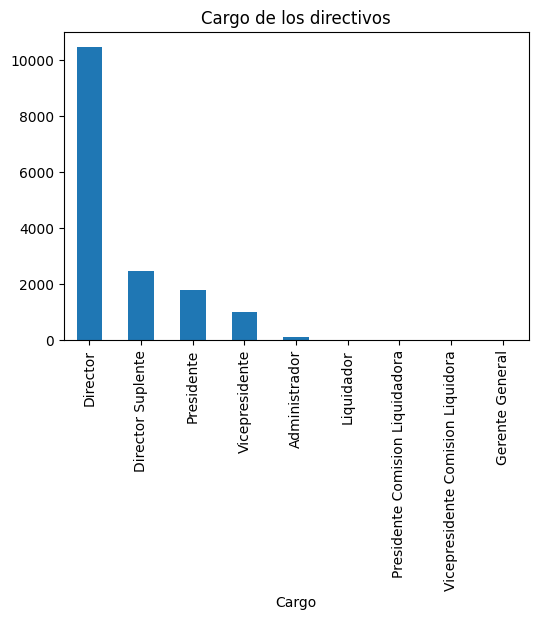

In [13]:
print(directivos_df['Cargo'].value_counts())

plt.figure(figsize=(6, 4))
directivos_df['Cargo'].value_counts().plot(kind='bar')
plt.title('Cargo de los directivos')
plt.show()

Es importante notar de aquí, que dentro de los cargos que considera el dataset, destaca mucho en cantidad el cargo de "Director", seguido por "Presidente", "Gerente" y "Vicepresidente".

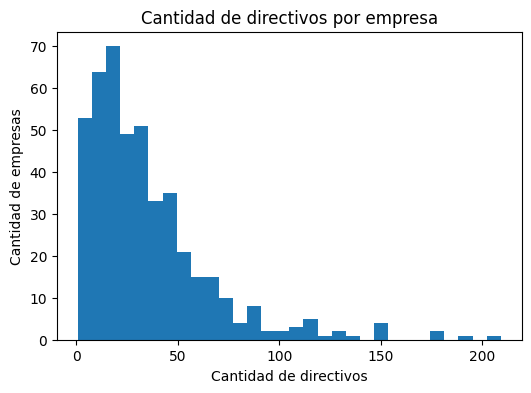

In [14]:
plt.figure(figsize=(6, 4))
directivos_df['Nombre_empresa'].value_counts().hist(bins=30, grid=False)
plt.title('Cantidad de directivos por empresa')
plt.xlabel('Cantidad de directivos')
plt.ylabel('Cantidad de empresas')
plt.show()

Nos gustaría revisar si las personas se repiten en los cargos de la empresa, oséa, si una persona ha sido varias veces director de una misma empresa.

In [15]:
directivos_df['Nombre'].value_counts().head()

Nombre
VICENTE DOMINGUEZ VIAL                 47
JORGE ADOLFO LESSER GARCIA-HUIDOBRO    46
JOSÉ RAMON VALENTE VIAS                46
ALBERTO EGUIGUREN CORREA               41
TETSURO TOYODA .                       40
Name: count, dtype: int64

Hay casos con muchas repeticiones. Sería interesante ver si estos casos son en la misma empresa o en distintas empresas. 

Para esto, tomamos como ejemplo el de la persona que tiene más repeticiones en el dataset, y analizamos en las empresas que ha estado.

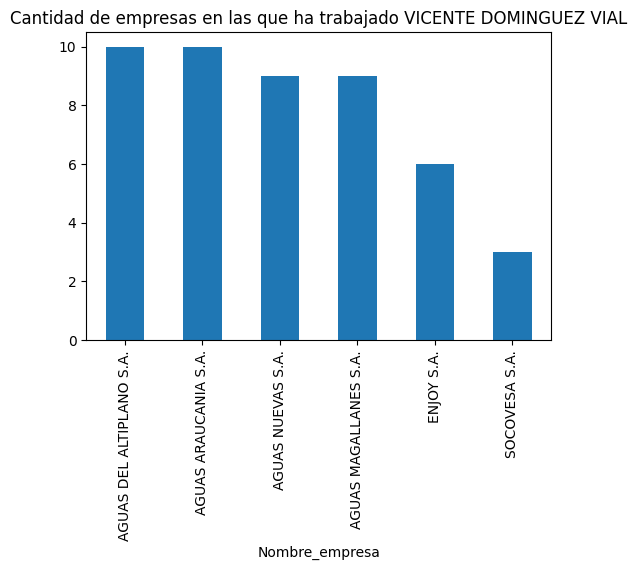

In [16]:
ejemplo_persona = "VICENTE DOMINGUEZ VIAL"
directivos_df[directivos_df['Nombre'] == ejemplo_persona]['Nombre_empresa'].value_counts()

plt.figure(figsize=(6, 4))
directivos_df[directivos_df['Nombre'] == ejemplo_persona]['Nombre_empresa'].value_counts().plot(kind='bar')
plt.title('Cantidad de empresas en las que ha trabajado ' + ejemplo_persona)
plt.show()

Se observa que en su caso el ha tenido cargos directivos en varias empresas.

Para analizar si existen relaciones familiares entre los directores de las empresas, **se necesita obtener los apellidos de las personas**.

## **Procesamiento de nombres**

En el estado inicial del dataset, se tienen los nombres completos de las personas que han sido directores de las empresas, sin embargo, nos interesa estudiar la relación de los apellidos con las empresas, por lo que se requiere separar los nombres de los apellidos.

Para esto se realizó un procesamiento de los nombres usando la API de OpenAI, específicamente el modelo gpt-4o-mini, donde, para cada nombre, se le solicitaba que devolviera solo los apellidos de la persona.

El código con el que se realizó este procesamiento se encuentra en el archivo `get_apellidos.ipynb`, y el resultado de esto se encuentra en el archivo `data/directors_and_companies_separated.csv`, el que contiene, además de los datos originales, los apellidos de las personas.

In [17]:
directivos_con_apellido = pd.read_csv(data_path + 'directors_and_companies_separated.csv')
directivos_con_apellido.head()

,Nombre,Nombre_empresa,Nombres,Primer_apellido,Segundo_apellido
0,LUIS ORVANANOS LASCURAIN,"CORPORACION GEO, S.A.B. DE C.V.",LUIS,ORVANANOS,LASCURAIN
1,EMILIO CUENCA FRIEDERICHSEN,"CORPORACION GEO, S.A.B. DE C.V.",EMILIO,CUENCA,FRIEDERICHSEN
2,ROBERTO ORVANANOS CONDE,"CORPORACION GEO, S.A.B. DE C.V.",ROBERTO,ORVANANOS,CONDE
3,INIGO ORVANANOS CORCUERA,"CORPORACION GEO, S.A.B. DE C.V.",INIGO,ORVANANOS,CORCUERA
4,RAUL ZORRILLA COSIO,"CORPORACION GEO, S.A.B. DE C.V.",RAUL,ZORRILLA,COSIO


## **Limpieza de datos**

Ahora nos gustaría quedarnos solo con la información que nos será útil para el análisis restante, que en particular, nos gustaría orientarlo a la relación de la cantidad de repeticiones de un apellido en una empresa.

Verificamos si hay algún dato que no tenga ni primer ni segundo apellido.

In [18]:
directivos_con_apellido[(directivos_con_apellido['Primer_apellido']=='') & (directivos_con_apellido['Segundo_apellido']=='')]

,Nombre,Nombre_empresa,Nombres,Primer_apellido,Segundo_apellido


Veamos que no nos interesa si una persona ha sido director de una empresa más de una vez, por lo que se deberían eliminar duplicados en caso de existir. En teoría la llave del dataset es la tupla (Nombre, Nombre_empresa), pero igualmente revisaremos si hay duplicados.

In [19]:
directivos_con_apellido.shape

(6946, 5)

In [20]:
directivos_con_apellido.drop_duplicates(subset=['Nombre', 'Nombre_empresa'], inplace=True)
directivos_con_apellido.shape

(6946, 5)

Considerando que las relaciones que buscamos estudiar son entre los apellidos y las empresas, las columnas que nos interesan son 'Nombre_empresa', 'Primer_apellido' y 'Segundo_apellido', por lo que eliminaremos el resto de las columnas.

In [21]:
empresas_apellidos = directivos_con_apellido[['Nombre_empresa', 'Primer_apellido', 'Segundo_apellido']]
empresas_apellidos.head()

,Nombre_empresa,Primer_apellido,Segundo_apellido
0,"CORPORACION GEO, S.A.B. DE C.V.",ORVANANOS,LASCURAIN
1,"CORPORACION GEO, S.A.B. DE C.V.",CUENCA,FRIEDERICHSEN
2,"CORPORACION GEO, S.A.B. DE C.V.",ORVANANOS,CONDE
3,"CORPORACION GEO, S.A.B. DE C.V.",ORVANANOS,CORCUERA
4,"CORPORACION GEO, S.A.B. DE C.V.",ZORRILLA,COSIO


## **Análisis de relaciones entre apellidos y empresas**

Ahora, para ver las relaciones interesantes entre apellido y empresa, y en particular la cantidad de veces que un apellido ha estado en una empresa, nos gustaría tener una tabla que fuera de la forma:

| Apellido | Empresa | Cantidad |
|----------|---------|----------|
| Pérez    | Empresa1| 3        |
| Pérez    | Empresa2| 2        |
| Pérez    | Empresa3| 1        |
| ...      | ...     | ...      |

Para esto lo primero es despivotear la tabla, para que cada fila sea un par (apellido, empresa), y luego agrupar por apellido y empresa, contando la cantidad de veces que un apellido ha estado en una empresa.

In [22]:
empresas_apellidos.shape

(6946, 3)

In [23]:
empresa_apellido = empresas_apellidos.melt(
    id_vars='Nombre_empresa', 
    value_vars=['Primer_apellido', 'Segundo_apellido'], 
    var_name='Apellido_orden',
    value_name='Apellido',
)
empresa_apellido.drop(columns='Apellido_orden', inplace=True)
empresa_apellido.head()

,Nombre_empresa,Apellido
0,"CORPORACION GEO, S.A.B. DE C.V.",ORVANANOS
1,"CORPORACION GEO, S.A.B. DE C.V.",CUENCA
2,"CORPORACION GEO, S.A.B. DE C.V.",ORVANANOS
3,"CORPORACION GEO, S.A.B. DE C.V.",ORVANANOS
4,"CORPORACION GEO, S.A.B. DE C.V.",ZORRILLA


In [24]:
empresa_apellido.shape

(13892, 2)

Guardamos el resultado en el archivo `../data/company_surname.csv`.

In [25]:
# Guardamos el dataset
# empresa_apellido.to_csv("../data/company_surname.csv", index=False)

### **Apellidos muy repetidos en alguna empresa**

In [26]:
conteo_appellido_empresa = empresa_apellido.groupby(['Nombre_empresa', 'Apellido']).size()
conteo_appellido_empresa = conteo_appellido_empresa.to_frame().reset_index(names=['Nombre_empresa', 'Apellido'])
conteo_appellido_empresa.columns = ['Nombre_empresa', 'Apellido', 'conteo']
conteo_appellido_empresa.sort_values('conteo', ascending=False).head()

,Nombre_empresa,Apellido,conteo
7359,MELON S.A.,BRESCIA,12
2861,COMPAÑIA DE INVERSIONES LA ESPAÑOLA S.A.,GARCIA,7
8837,SIPSA SOCIEDAD ANONIMA,MENENDEZ,7
6754,INVERSIONES HISPANIA S.A.,GARCIA,6
399,AGROSUPER S.A.,VIAL,6


Guardamos el resultado en el archivo `../data/company_surname_count.csv`.

In [27]:
# Guardamos el dataset
# conteo_appellido_empresa.to_csv("../data/company_surname_count.csv", index=False)

In [28]:
conteo_appellido_empresa_filtrado = conteo_appellido_empresa[conteo_appellido_empresa['conteo'] > 5]
conteo_appellido_empresa_filtrado.head()

,Nombre_empresa,Apellido,conteo
399,AGROSUPER S.A.,VIAL,6
2861,COMPAÑIA DE INVERSIONES LA ESPAÑOLA S.A.,GARCIA,7
5307,FALABELLA S.A.,SOLARI,6
6463,INMOBILIARIA SIXTERRA S.A.,NAVARRETE,6
6754,INVERSIONES HISPANIA S.A.,GARCIA,6


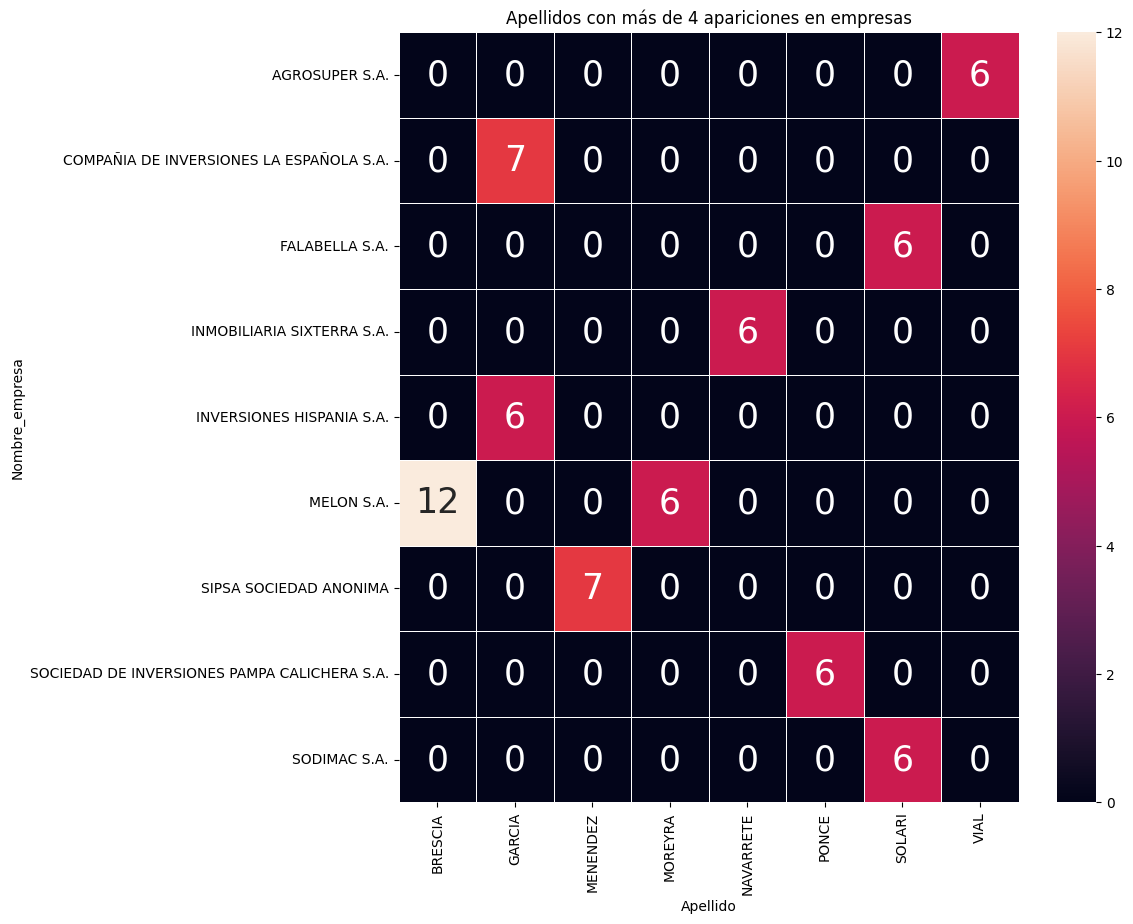

In [29]:
matriz_apellidos_empresa = conteo_appellido_empresa_filtrado.pivot(index='Nombre_empresa', columns='Apellido', values='conteo').fillna(0)

plt.figure(figsize=(10, 10))
plt.title('Apellidos con más de 4 apariciones en empresas')
sns.heatmap(matriz_apellidos_empresa, 
            annot=True,
            annot_kws={'size': 25},
            linewidths=0.5,
            linecolor='white')

plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

### **Apellidos que se repiten en muchas empresas**

In [30]:
conteo_empresas_por_apellido = empresa_apellido.groupby('Apellido')['Nombre_empresa'].nunique()
conteo_empresas_por_apellido = conteo_empresas_por_apellido.to_frame().reset_index()
conteo_empresas_por_apellido.columns = ['Apellido', 'Cantidad_empresas']
conteo_empresas_por_apellido.sort_values('Cantidad_empresas', ascending=False).head(10)

,Apellido,Cantidad_empresas
1505,GONZALEZ,93
1429,GARCIA,87
1961,LARRAIN,77
2959,RODRIGUEZ,77
894,CORREA,77
2686,PEREZ,76
1296,FERNANDEZ,70
2428,MUNOZ,62
3567,VIAL,61
3230,SILVA,61


In [31]:
conteo_empresas_por_apellido_filtrado = conteo_empresas_por_apellido[conteo_empresas_por_apellido['Cantidad_empresas'] > 15]

# ploteamos el histograma de la cantidad de apellidos que tienen cada cantidad de empresas
px.histogram(
    conteo_empresas_por_apellido_filtrado, 
    x='Cantidad_empresas', 
    title='Cantidad de apellidos que han dirigido en más de 20 empresas',
    nbins=30,
)

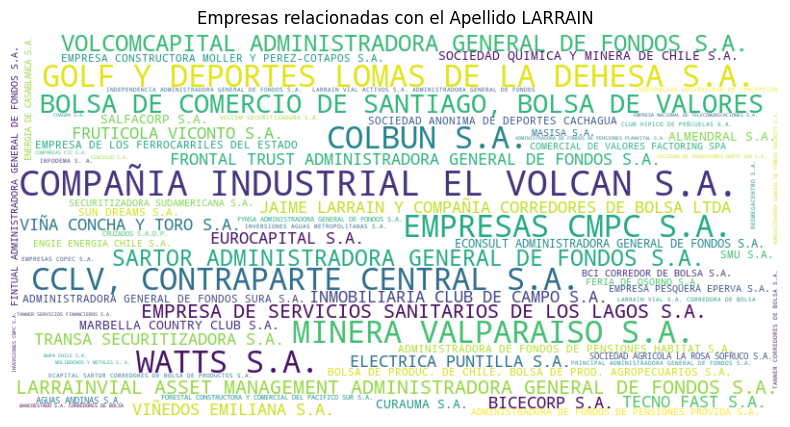

In [32]:
from wordcloud import WordCloud

# Función para generar nubes de palabras
def generar_nube_de_palabras(df, apellido):
    # Filtrar el DataFrame por el apellido específico
    df_filtrado = df[df['Apellido'] == apellido]
    
    # Contar la frecuencia de las empresas para ese apellido
    frecuencias = df_filtrado['Nombre_empresa'].value_counts().to_dict()
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frecuencias)
    
    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')  # Ocultar los ejes
    plt.title(f"Empresas relacionadas con el Apellido {apellido}")
    plt.show()

# Ejemplo: Crear una nube de palabras para el apellido 'Perez'
generar_nube_de_palabras(empresa_apellido, 'LARRAIN')

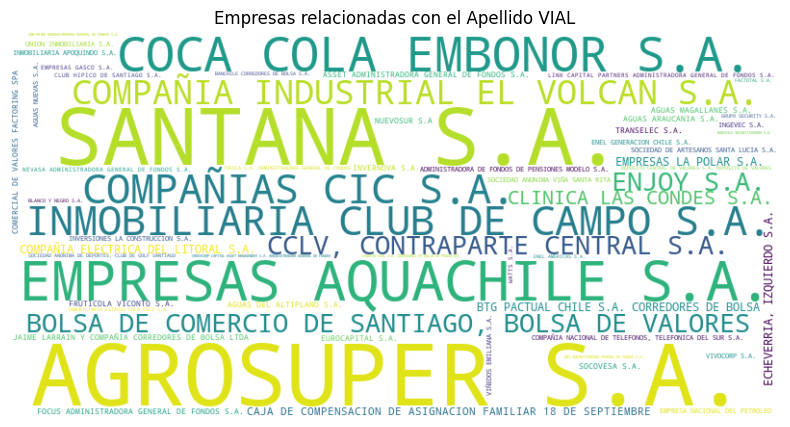

In [33]:
generar_nube_de_palabras(empresa_apellido, 'VIAL')

### **Visualizar un apellido y sus empresas relacionadas**

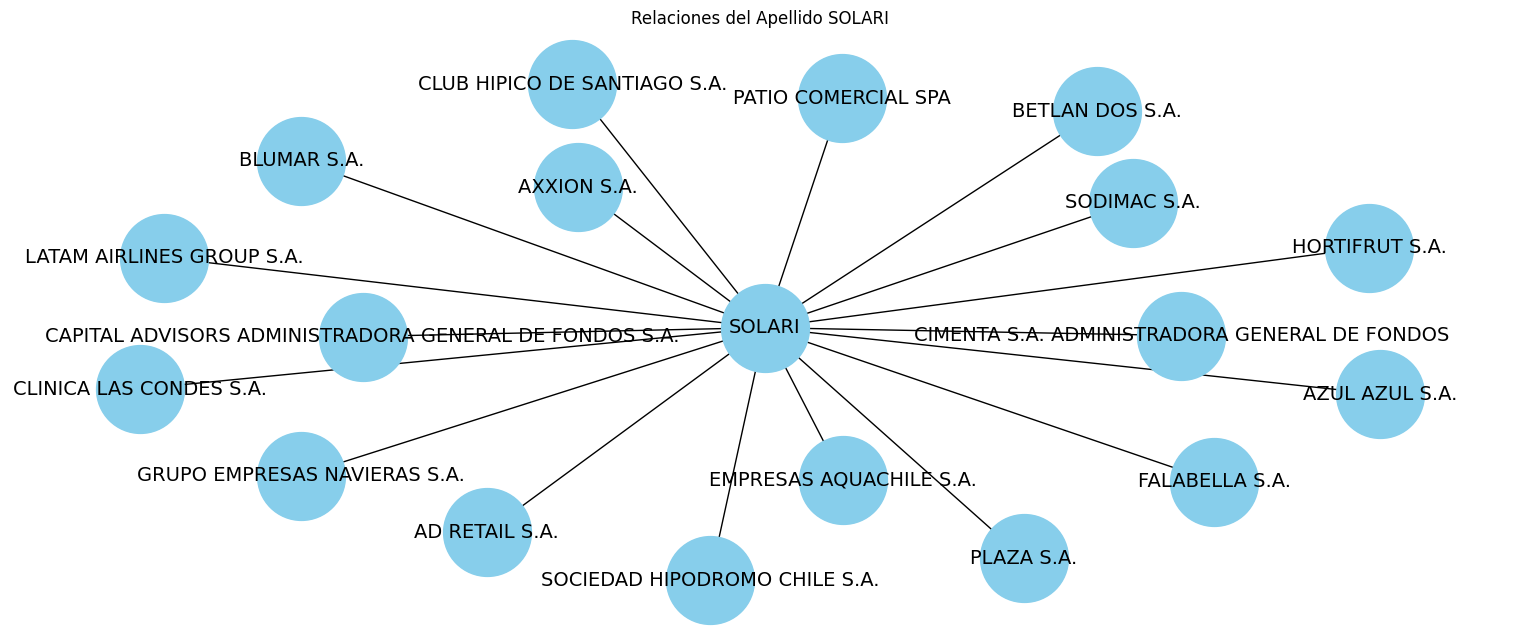

In [ ]:
apellido = "SOLARI"

# Crear un grafo vacío
grafo = nx.Graph()

# Agregar apellido como nodo
grafo.add_node(apellido)

# Filtrar el DataFrame por el apellido específico
df_filtrado = empresa_apellido[empresa_apellido['Apellido'] == apellido]

# Iterar sobre las filas del DataFrame
for idx, row in df_filtrado.iterrows():
    # Obtener el nombre de la empresa
    empresa = row['Nombre_empresa']
    
    # Agregar la empresa como nodo
    grafo.add_node(empresa)
    
    # Agregar una arista entre el apellido y la empresa
    grafo.add_edge(apellido, empresa)
    
# Dibujar el grafo
pos = nx.spring_layout(grafo)
plt.figure(figsize=(15, 6))
nx.draw(grafo, pos, with_labels=True, font_size=14, node_size=4000, node_color='skyblue')
plt.title(f"Relaciones del Apellido {apellido}")
plt.show()


### **Caso de estudio: Melon S.A.**

In [35]:
melon_sa_count = conteo_appellido_empresa[
    conteo_appellido_empresa['Nombre_empresa'] == 'MELON S.A.'
    ]

melon_sa_count.sort_values('conteo', ascending=False).head()

,Nombre_empresa,Apellido,conteo
7359,MELON S.A.,BRESCIA,12
7366,MELON S.A.,MOREYRA,6
7360,MELON S.A.,CAFFERATA,3
7358,MELON S.A.,ARAOZ,1
7361,MELON S.A.,CAREY,1


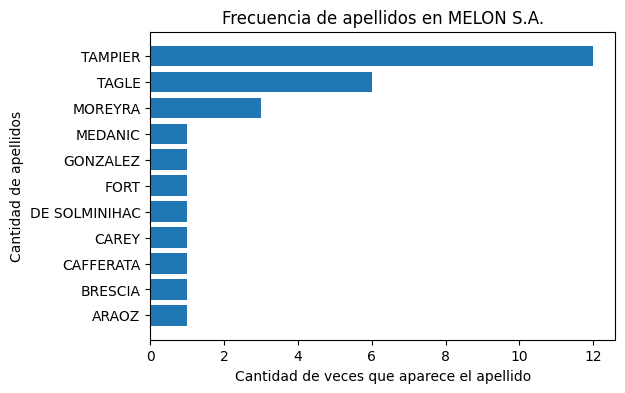

In [36]:
plt.figure(figsize=(6, 4))
plt.barh(melon_sa_count['Apellido'], melon_sa_count['conteo'].sort_values(ascending=True))
plt.xlabel('Cantidad de veces que aparece el apellido')
plt.ylabel('Cantidad de apellidos')
plt.title('Frecuencia de apellidos en MELON S.A.')
plt.show()

In [37]:
directivos_con_apellido[directivos_con_apellido['Nombre'].str.contains('BRESCIA')]

,Nombre,Nombre_empresa,Nombres,Primer_apellido,Segundo_apellido
734,ALEX PAUL FORT BRESCIA,MELON S.A.,ALEX PAUL,FORT,BRESCIA
735,MARIO AUGUSTO BRESCIA CAFFERATA,MELON S.A.,MARIO AUGUSTO,BRESCIA,CAFFERATA
736,PEDRO BRESCIA CAFFERATA,MELON S.A.,PEDRO,BRESCIA,CAFFERATA
737,MARIO AUGUSTO MIGUEL BRESCIA MOREYRA,MELON S.A.,MARIO AUGUSTO MIGUEL,BRESCIA,MOREYRA
738,MARIO BRESCIA CAFFERATA,MELON S.A.,MARIO,BRESCIA,CAFFERATA
742,BERNARDO FORT BRESCIA,MELON S.A.,BERNARDO FORT,BRESCIA,NaN
743,PEDRO MANUEL JUAN BRESCIA MOREYRA,MELON S.A.,PEDRO MANUEL JUAN,BRESCIA,MOREYRA
744,FORTUNATO JUAN JOSE BRESCIA MOREYRA,MELON S.A.,FORTUNATO JUAN JOSE,BRESCIA,MOREYRA
746,FORTUNATO BRESCIA MOREYRA,MELON S.A.,FORTUNATO,BRESCIA,MOREYRA
747,MARIO BRESCIA MOREYRA,MELON S.A.,MARIO,BRESCIA,MOREYRA


### **Caso de estudio: SIPSA Socidad Anónima**

In [38]:
sipsa_conteo = conteo_appellido_empresa[
    conteo_appellido_empresa['Nombre_empresa'] == 'SIPSA SOCIEDAD ANONIMA'
    ]

sipsa_conteo.sort_values('conteo', ascending=False).head()

,Nombre_empresa,Apellido,conteo
8837,SIPSA SOCIEDAD ANONIMA,MENENDEZ,7
8838,SIPSA SOCIEDAD ANONIMA,ROSS,3
8833,SIPSA SOCIEDAD ANONIMA,BARROS,2
8839,SIPSA SOCIEDAD ANONIMA,SAN MARTIN,2
8840,SIPSA SOCIEDAD ANONIMA,TOCORNAL,2


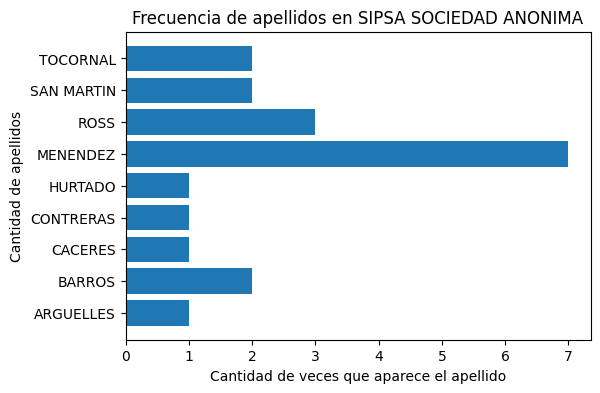

In [39]:
plt.figure(figsize=(6, 4))
plt.barh(sipsa_conteo['Apellido'], sipsa_conteo['conteo'])
plt.xlabel('Cantidad de veces que aparece el apellido')
plt.ylabel('Cantidad de apellidos')
plt.title('Frecuencia de apellidos en SIPSA SOCIEDAD ANONIMA')
plt.show()

In [40]:
directivos_con_apellido[directivos_con_apellido['Nombre'].str.contains('MENENDEZ')]

,Nombre,Nombre_empresa,Nombres,Primer_apellido,Segundo_apellido
967,ROBERTO IZQUIERDO MENENDEZ,NITRATOS DE CHILE S.A.,ROBERTO,IZQUIERDO,MENENDEZ
991,GONZALO SEBASTIAN MENENDEZ DUQUE,SOCIEDAD MATRIZ SAAM S.A.,Gonzalo Sebastian,Menendez,Duque
2611,GONZALO SEBASTIAN MENENDEZ DUQUE,COMPAÑIA SUD AMERICANA DE VAPORES S.A.,Gonzalo Sebastian,Menendez,Duque
3530,GONZALO SEBASTIAN MENENDEZ DUQUE,QUIÑENCO S.A.,GONZALO SEBASTIAN,MENENDEZ,DUQUE
4033,SERGIO LECAROS MENENDEZ,SOCIEDAD PESQUERA COLOSO S.A.,SERGIO,LECAROS,MENENDEZ
4037,PEDRO LECAROS MENENDEZ,SOCIEDAD PESQUERA COLOSO S.A.,PEDRO,LECAROS,MENENDEZ
4277,ROBERTO IZQUIERDO MENENDEZ,ALMENDRAL S.A.,ROBERTO,IZQUIERDO,MENENDEZ
4620,RICARDO MENENDEZ ROSS,SIPSA SOCIEDAD ANONIMA,RICARDO,MENENDEZ,ROSS
4621,JULIO MENENDEZ ROSS,SIPSA SOCIEDAD ANONIMA,JULIO,MENENDEZ,ROSS
4622,FELIPE MENENDEZ ROSS,SIPSA SOCIEDAD ANONIMA,FELIPE,MENENDEZ,ROSS
